# Set up local SparkSession

In [1]:
from pyspark.sql import SparkSession, Row
import pyspark.sql.functions as F

In [2]:
spark = (
    SparkSession
    .builder
    .master("local[*]")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.repl.eagerEval.maxNumRows", 10)
    .getOrCreate()
)

21/08/14 19:11:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


# Read weather data

In [3]:
df = (
    spark
    .read
    .option("header", True)
    .option("inferSchema", True)
    .csv("weather.csv")
).cache()

# Show DataFrame

In [4]:
df

date,temperature_max_f,temperature_mean_f,temperature_min_f,dew_point_max_f,dew_point_mean_f,dew_point_min_f,humidity_max,humidity_mean,humidity_min,sea_level_pressure_max_in,sea_level_pressure_mean_in,sea_level_pressure_min_in,visibility_max_miles,visibility_mean_miles,visibility_min_miles,wind_speed_max_mph,wind_speed_mean_mph,gust_speed_max_mph,precipitation_in,cloud_cover,events,wind_degrees
1/1/2014,34,29,24,18,13,5,60,49,38,30.43,30.36,30.27,10,10,10,18,9,23,0,5,null,297
1/2/2014,33,26,19,25,21,15,91,71,51,30.24,29.94,29.67,10,7,0,29,18,36,0.13,8,Snow,32
1/3/2014,19,14,9,13,4,-7,88,65,42,30.48,30.05,29.62,10,5,0,33,20,44,0.22,3,Fog-Snow,335
1/4/2014,31,17,3,18,5,-5,67,52,36,30.55,30.45,30.33,10,10,10,17,7,21,0,3,null,250
1/5/2014,49,36,23,48,31,17,93,81,68,30.34,30.18,29.79,10,5,0,23,7,31,0.1,7,Fog-Rain,88
1/6/2014,53,37,20,52,38,3,100,72,43,29.75,29.57,29.44,10,5,0,38,21,45,0.41,7,Fog-Rain-Snow,227
1/7/2014,20,13,6,-5,-12,-17,46,39,32,30.41,30.17,29.8,10,10,10,38,23,46,0,1,null,277
1/8/2014,24,17,10,2,-3,-7,52,44,36,30.58,30.51,30.43,10,10,10,22,13,28,0,3,null,273
1/9/2014,34,28,22,15,8,2,63,48,32,30.67,30.61,30.52,10,10,10,15,7,20,0,4,null,312
1/10/2014,38,31,24,36,29,16,92,78,63,30.59,30.43,30.23,10,4,0,7,4,8,0.19,8,Rain-Snow,21


# Plot minimum and maximum snow temperatures per year, in Celsius

<AxesSubplot:xlabel='year'>

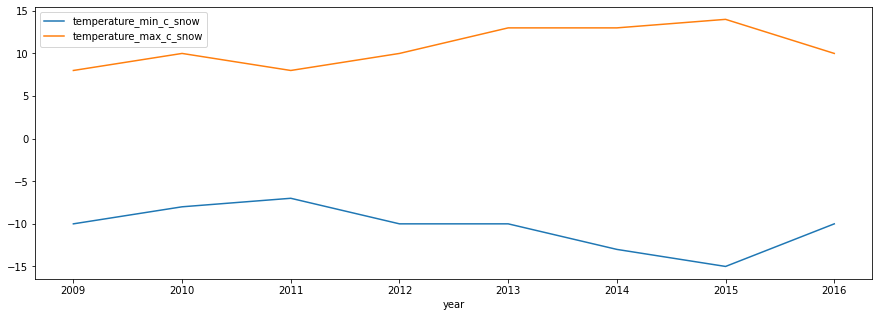

In [5]:
(
    df
    .where("lower(events) like '%snow%'")
    .withColumn("date", F.to_date(F.col("date"), "M/d/yyyy"))
    .withColumn("temperature_min_c", ((F.col("temperature_min_f") - 32) * 5/9).cast("int"))
    .withColumn("temperature_max_c", ((F.col("temperature_max_f") - 32) * 5/9).cast("int"))
    .groupBy(F.year("date"))
    .agg({"temperature_min_c": "min", "temperature_max_c": "max"})
    .withColumnRenamed("year(date)", "year")
    .withColumnRenamed("min(temperature_min_c)", "temperature_min_c_snow")
    .withColumnRenamed("max(temperature_max_c)", "temperature_max_c_snow")
    .orderBy("year")
    .toPandas()
    .plot(x="year", y=["temperature_min_c_snow", "temperature_max_c_snow"], figsize=(15, 5))
)